In [1]:
# Importing necessary libraries and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from kerastuner import RandomSearch, HyperModel, BayesianOptimization, Objective
from kerastuner.engine.hyperparameters import HyperParameters
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import EfficientNetB7
import time
import scipy

In [2]:
# Reading the dataset

#DATA_DIR = 'C:/Users/Sharmad/OneDrive - Rensselaer Polytechnic Institute/Documents/ITWS6600/Project/cloud_street'
DATA_DIR = '/data/Sharmad/cloud_images'
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, batch_size=32, image_size=(256, 256))

Found 6641 files belonging to 2 classes.


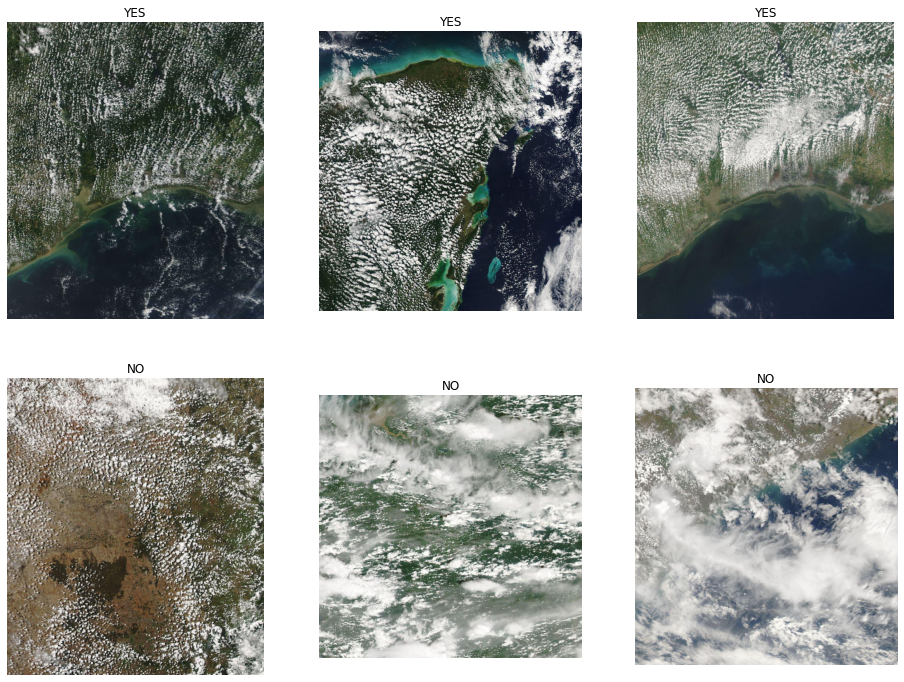

In [3]:
# Exploratory Data Analysis

# Viewing the images

# get the list of image files from the class folders
yes_imgs = [img for img in os.listdir(f'{DATA_DIR}/yes')]
no_imgs = [img for img in os.listdir(f'{DATA_DIR}/no')]

# randomly select 3 of each
select_yes = np.random.choice(yes_imgs, 3, replace = False)
select_no = np.random.choice(no_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (16,12))
for i in range(6):
    if i < 3:
        fp = f'{DATA_DIR}/yes/{select_yes[i]}'
        label = 'YES'
    else:
        fp = f'{DATA_DIR}/no/{select_no[i-3]}'
        label = 'NO'
    ax = fig.add_subplot(2, 3, i+1)
    
    fn = image.load_img(fp)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [4]:
# Converting images to numpy arrays

# np_data = []
# label = []

# # Class YES

# for i, image_name in enumerate(yes_imgs):
#     try:
#       if (image_name.split('.')[1] == 'jpg'):
#         image = load_img(f'{DATA_DIR}/yes/{image_name}')
#         image = image.resize((256,256))
#         image_array = img_to_array(image)
#         np_data.append(image_array)
#         label.append(1)
#     except Exception:
#         print(f'Could not read image {i} with name {image_name}')
        
# Preprocessed input

np_data = []
label = []

# Class YES

for i, image_name in enumerate(yes_imgs):
    try:
      if (image_name.split('.')[1] == 'jpg'):
        image = load_img(f'{DATA_DIR}/yes/{image_name}')
        image = image.resize((256,256))
        image_array = img_to_array(image)
        image_array = preprocess_input(image_array)
        np_data.append(image_array)
        label.append(1)
    except Exception:
        print(f'Could not read image {i} with name {image_name}')

In [5]:
# Class NO

# for i, image_name in enumerate(no_imgs):
#     try:
#       if (image_name.split('.')[1] == 'jpg'):
#         image = load_img(f'{DATA_DIR}/no/{image_name}')
#         image = image.resize((256,256))
#         image_array = img_to_array(image)
#         np_data.append(image_array)
#         label.append(0)
#     except Exception:
#         print(f'Could not read image {i} with name {image_name}')

# Preprocessed input

for i, image_name in enumerate(no_imgs):
    try:
      if (image_name.split('.')[1] == 'jpg'):
        image = load_img(f'{DATA_DIR}/no/{image_name}')
        image = image.resize((256,256))
        image_array = img_to_array(image)
        image_array = preprocess_input(image_array)
        np_data.append(image_array)
        label.append(0)
    except Exception:
        print(f'Could not read image {i} with name {image_name}')

In [6]:
# Splitting the dataset into training and testing dataset
from tensorflow.keras.utils import to_categorical

X_train2, X_test2, y_train2, y_test2 = train_test_split(np_data, to_categorical(np.array(label)), 
                                                        test_size = 0.20, random_state=42)

In [ ]:
# Hyper Parameter tuning with Keras Tuner
SIZE=256
classifier = None
LOG_DIR = f"{int(time.time())}"

def hypermodel(hp):
  classifier = Sequential()
  classifier.add(Convolution2D(hp.Int("input_units", min_value=32,
                                      max_value=256, step=32), (3, 3), 
                                      input_shape = (SIZE, SIZE, 3), 
                                      activation = 'relu', 
                                      data_format='channels_last'))
  classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
  classifier.add(BatchNormalization(axis = -1))
  classifier.add(Dropout(0.2))
  for i in range(hp.Int("n_layers", 3,4)):
    classifier.add(Convolution2D(hp.Int(f"conv_{i}_unts", min_value=32,
                                      max_value=256, step=32), (3, 3), 
                                      input_shape = (SIZE, SIZE, 3), 
                                      activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
    classifier.add(BatchNormalization(axis = -1))
    classifier.add(Dropout(0.2))
  classifier.add(Flatten())
  classifier.add(Dense(activation = 'relu', units=512))
  classifier.add(BatchNormalization(axis = -1))
  classifier.add(Dropout(0.2))
  classifier.add(Dense(activation = 'relu', units=256))
  classifier.add(BatchNormalization(axis = -1))
  classifier.add(Dropout(0.2))
  classifier.add(Dense(activation = 'sigmoid', units=2))
  classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return classifier

#model = build_model()
#print(model.summary())

In [ ]:
# Data Augmentation for adding images to the dataset

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode="reflect",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,
    dtype=None,
)


# for i in range(6):
#   if i < 3:
#         fp = f'{DATA_DIR}/yes/{select_yes[i]}'
#         fs = f'{DATA_DIR}/yes'
#         label = 'YES'
#   else:
#         fp = f'{DATA_DIR}/no/{select_no[i-3]}'
#         fs = f'{DATA_DIR}/no'
#         label = 'NO'
    
#   fn = image.load_img(fp)
#   img_ary = img_to_array(fn)
#   img_ary = img_ary.reshape((1,) + img_ary.shape)

#   j=0
#   for batch in datagen.flow(img_ary, batch_size=1, save_to_dir = fs, 
#                               save_prefix=label, save_format='jpeg'):
#     j += 1
#     if j > 2:
#       break # otherwise the generator would loop indefinitely



In [ ]:
datagen.fit(X_train)

In [ ]:
# Keras-Tuner

tuner = BayesianOptimization(
    hypermodel = hypermodel,
    objective = Objective("val_loss", 'min'),
    max_trials = 15,
    executions_per_trial=2,
    directory = LOG_DIR,
    overwrite=True
)

train_gen = datagen.flow(np.array(X_train), np.array(y_train), batch_size=32, subset='training')
val_gen = datagen.flow(np.array(X_train), np.array(y_train), batch_size=32, subset='validation')

In [ ]:
tuner.search(train_gen,
            epochs=15,
            validation_data=val_gen)

tuner.results_summary()
tuner.get_best_models()[0].summary()

In [ ]:
# Bulding the keras tuner model and tweaking it manually

#classifier = tuner.get_best_models()[0]
SIZE=256
classifier = None
classifier = Sequential()
classifier.add(Convolution2D(96, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(224, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(256, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=2))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

In [ ]:
# Fitting the tweaked model on training data

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode ="max", patience=50, restore_best_weights = True)

#history = classifier.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=32, subset='training'),
#                    steps_per_epoch=(0.8*len(X_train)) / 32,
#                    epochs=150,
#                    validation_data=datagen.flow(np.array(X_train), np.array(y_train), batch_size=32, subset='validation'),
#                    validation_steps=(0.2*len(X_train)) / 32, callbacks = [callback])

#history = classifier.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=32),
#          steps_per_epoch=len(X_train) / 32, epochs=100, verbose=1, validation_split = 0.1)


history1 =  classifier.fit(np.array(X_train2), 
                          y_train2, 
                          batch_size = 32, 
                          verbose = 1, 
                          epochs = 150, 
                          validation_split = 0.2,
                          shuffle = True,callbacks=[callback])

In [ ]:
classifier.save("my_model_3")

In [ ]:
cnn_model_3 = tf.keras.models.load_model('my_model_3')

In [ ]:
# Test Accuracy

model_acc = cnn_model_3.evaluate(np.array(X_test2), np.array(y_test2))[1]
print(f'Test_Accuracy: {model_acc*100}')

# 69% accuracy with keras tuner model
# with increasing number of epochs analyze the changes (callback feature enabled)

In [ ]:
# Training accuracy

max_len = int(len(y_train2)*0.8)

cnn_model_3.evaluate(np.array(X_train2)[:max_len], np.array(y_train2)[:max_len])

In [7]:
### Transfer Learning ###

# base_model = InceptionResNetV2(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.
#     input_shape=(256, 256, 3),
#     include_top=False)

# base_model = VGG19(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.
#     input_shape=(256, 256, 3),
#     include_top=False)

base_model = EfficientNetB7(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)

base_model.trainable = False

transfer_model = tf.keras.Sequential([
    base_model,
    Flatten(),
    tf.keras.layers.Dense(activation = 'sigmoid', units=2)
])

transfer_model.summary()

transfer_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

258080768/258076736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
flatten (Flatten)            (None, 163840)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 327682    
Total params: 64,425,369
Trainable params: 327,682
Non-trainable params: 64,097,687
_________________________________________________________________


In [8]:
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode ="max", patience=50, restore_best_weights = True)

fit_obj = transfer_model.fit(np.array(X_train2), 
                          y_train2, 
                          batch_size = 32, 
                          verbose = 1, 
                          epochs = 150, 
                          validation_split = 0.2,
                          shuffle = True,
                          callbacks=[callback2])

Epoch 1/150
133/133 [==============================] - 761s 6s/step - loss: 3.5843 - accuracy: 0.7169 - val_loss: 2.9248 - val_accuracy: 0.7563
Epoch 2/150
133/133 [==============================] - 729s 5s/step - loss: 2.3383 - accuracy: 0.7994 - val_loss: 4.1996 - val_accuracy: 0.7272
Epoch 3/150
133/133 [==============================] - 736s 6s/step - loss: 1.5313 - accuracy: 0.8456 - val_loss: 2.6142 - val_accuracy: 0.8109
Epoch 4/150
133/133 [==============================] - 738s 6s/step - loss: 1.7650 - accuracy: 0.8630 - val_loss: 2.2918 - val_accuracy: 0.8203
Epoch 5/150
133/133 [==============================] - 738s 6s/step - loss: 0.8014 - accuracy: 0.9003 - val_loss: 3.1191 - val_accuracy: 0.8034
Epoch 6/150
133/133 [==============================] - 739s 6s/step - loss: 1.5042 - accuracy: 0.8808 - val_loss: 2.3978 - val_accuracy: 0.8260
Epoch 7/150
133/133 [==============================] - 770s 6s/step - loss: 0.9433 - accuracy: 0.9080 - val_loss: 2.9972 - val_accuracy:

133/133 [==============================] - 738s 6s/step - loss: 0.3200 - accuracy: 0.9773 - val_loss: 7.7892 - val_accuracy: 0.8166
Epoch 58/150
133/133 [==============================] - 739s 6s/step - loss: 0.7144 - accuracy: 0.9586 - val_loss: 7.2229 - val_accuracy: 0.8288
Epoch 59/150
133/133 [==============================] - 743s 6s/step - loss: 0.1639 - accuracy: 0.9869 - val_loss: 7.7202 - val_accuracy: 0.8288
Epoch 60/150
133/133 [==============================] - 744s 6s/step - loss: 0.5031 - accuracy: 0.9692 - val_loss: 10.0976 - val_accuracy: 0.7968
Epoch 61/150
133/133 [==============================] - 743s 6s/step - loss: 0.4157 - accuracy: 0.9735 - val_loss: 7.3100 - val_accuracy: 0.8382
Epoch 62/150
133/133 [==============================] - 740s 6s/step - loss: 0.2889 - accuracy: 0.9796 - val_loss: 7.4637 - val_accuracy: 0.8119
Epoch 63/150
133/133 [==============================] - 745s 6s/step - loss: 0.2314 - accuracy: 0.9834 - val_loss: 8.6699 - val_accuracy: 0.79

In [9]:
# Test accuracy

transfer_model_acc = transfer_model.evaluate(np.array(X_test2), np.array(y_test2))[1]
print(f'Test Accuracy for Transfer learning model: {transfer_model_acc*100}')

42/42 [==============================] - 183s 4s/step - loss: 8.8367 - accuracy: 0.8029
Test Accuracy for Transfer learning model: 80.28593063354492


In [10]:
# Training accuracy

transfer_model.evaluate(np.array(X_train2), np.array(y_train2))

166/166 [==============================] - 772s 5s/step - loss: 1.4953 - accuracy: 0.9654


[1.495339274406433, 0.9653614163398743]

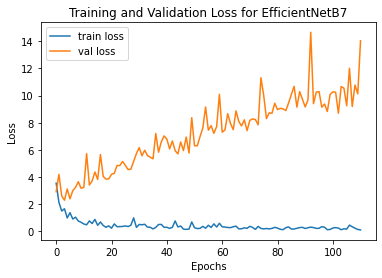

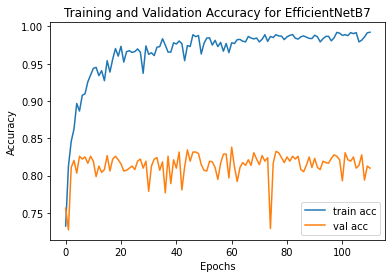

In [11]:
# loss
fig1 = plt.plot(fit_obj.history['loss'], label='train loss')
fig1 = fig1 + plt.plot(fit_obj.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for EfficientNetB7")
plt.savefig('LossVal_loss_EfficientNetB7.png')
plt.show()


# accuracies
plt.plot(fit_obj.history['accuracy'], label='train acc')
plt.plot(fit_obj.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy for EfficientNetB7")
plt.savefig('AccVal_acc_EfficientNetB7.png')
plt.show()